## Setup

In [1]:
# Facial image emotion recognition using CNN
# Target classes: Angry, Disgusted, Fearful, Happy, Sad, Surprised, Neutral

import tensorflow as tf

NUM_THREADS = 32

tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# Switch to GPU
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("Num GPUs Available: ", len(physical_devices))
print(physical_devices)
for dev in physical_devices:
    tf.config.experimental.set_memory_growth(dev, True)


# DATASET
# files in dataset/test and dataset/train
# subfolders: angry, disgusted, fearful, happy, sad, surprised, neutral

# load dataset
train_dir = "dataset/train"
test_dir = "dataset/test"

2024-07-10 22:34:50.450607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 22:34:50.473912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 22:34:50.473949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 22:34:50.489932: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 22:34:51.317656: W tensorflow/com

Num GPUs Available:  2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# Test data
# Check for the number of images in each class and the size of the images
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"  # 0 = alle Meldungen werden ausgegeben

# List of classes
classes = ["angry", "disgust", "fear", "happy", "sad", "surprise", "neutral"]

# Number of images in each class
print("Number of training images in each class:")
for c in classes:
    path = os.path.join(train_dir, c)
    print(f"{c}: {len(os.listdir(path))} images")

print("\nNumber of test images in each class:")
for c in classes:
    path = os.path.join(test_dir, c)
    print(f"{c}: {len(os.listdir(path))} images")

# Image size
img = cv2.imread("dataset/train/angry/Training_3908.jpg")
print(f"\nImage size: {img.shape}")

input_shape = img.shape

# Reduce image size to 48x48 pixels due to greyscale (original size: 48x48x3)
input_shape = (48, 48, 1)

Number of training images in each class:
angry: 4162 images
disgust: 411 images
fear: 4171 images
happy: 7628 images
sad: 5073 images
surprise: 2842 images
neutral: 5248 images

Number of test images in each class:
angry: 939 images
disgust: 84 images
fear: 982 images
happy: 1850 images
sad: 1270 images
surprise: 610 images
neutral: 1255 images

Image size: (48, 48, 3)


## Loading the images from disk

In [3]:
import dataloader

greyscale = True
augmentation = None

train_ds, test_ds = dataloader.load(
    train_dir, test_dir, 7, OneChannelOnly=greyscale, augmentations=augmentation
)

Found 29535 files belonging to 7 classes.


2024-07-10 22:34:54.572729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22989 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-07-10 22:34:54.573285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22931 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:65:00.0, compute capability: 7.5


Found 6990 files belonging to 7 classes.


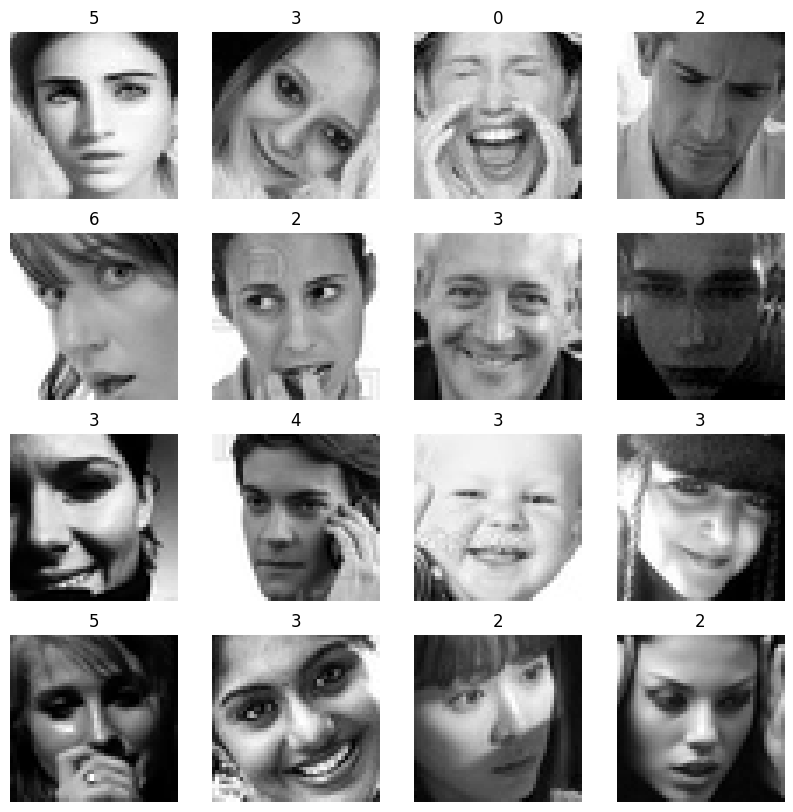

2024-07-10 22:34:56.933964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Show the first 16 images and their labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        if greyscale:
            plt.imshow(np.squeeze(images[i]), cmap="gray")
        else:
            plt.imshow(images[i])
        plt.title(np.argmax(labels[i]))
        plt.axis("off")
    plt.show()

Image shape: (64, 48, 48, 1), Label dtype: <dtype: 'float32'>
Image dtype: <dtype: 'float32'>, Label dtype: <dtype: 'float32'>


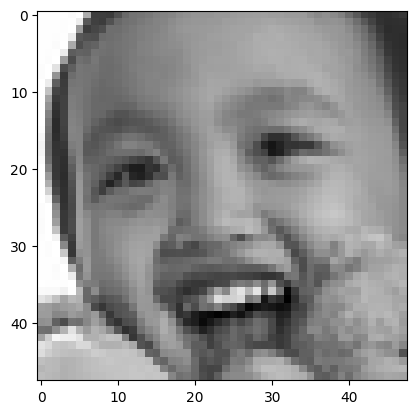

2024-07-10 22:34:57.058815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
# Print one image (to confirm whether the images are represented as 48x48x1 tensors)
for img, label in train_ds.take(1):
    print(f"Image shape: {img.shape}, Label dtype: {label.dtype}")
    print(f"Image dtype: {img.dtype}, Label dtype: {label.dtype}")

    # Plot the image
    if greyscale:
        plt.imshow(np.squeeze(img[0]), cmap="gray")
    else:
        plt.imshow(img[0])
    plt.show()

## Class distribution and weights

Train Class Distribution: Counter({3: 1850, 5: 1270, 4: 1255, 2: 982, 0: 939, 6: 610, 1: 84})


2024-07-10 22:34:57.175696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test Class Distribution: Counter({3: 7628, 4: 5248, 5: 5073, 2: 4171, 0: 4162, 6: 2842, 1: 411})


2024-07-10 22:34:57.519600: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


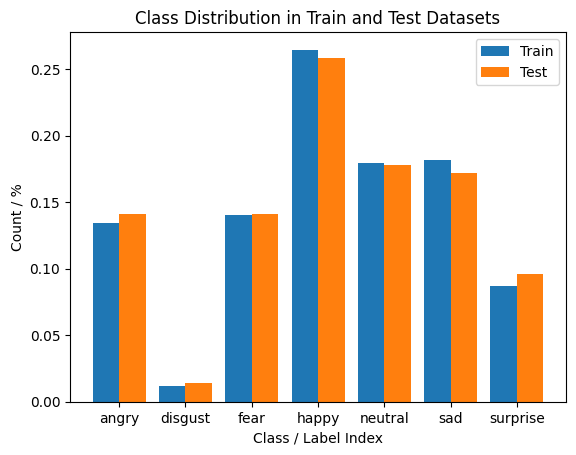

In [6]:
import collections


def get_class_distribution(dataset):
    class_counts = collections.Counter()

    for _, label_batch in dataset:
        labels = tf.argmax(label_batch, axis=1)
        class_counts.update(labels.numpy())

    return class_counts


# Klassenverteilung im Trainingsdatensatz
train_class_distribution = get_class_distribution(train_ds)
print("Train Class Distribution:", train_class_distribution)

# Klassenverteilung im Testdatensatz
test_class_distribution = get_class_distribution(test_ds)
print("Test Class Distribution:", test_class_distribution)


def plot_class_distributions(train_distribution, test_distribution, class_labels):
    classes = sorted(
        set(train_distribution.keys()).union(set(test_distribution.keys()))
    )

    train_counts = [train_distribution[cls] for cls in classes]
    test_counts = [test_distribution[cls] for cls in classes]

    width = 0.4  # width of the bars
    x = range(len(classes))  # the label locations

    fig, ax = plt.subplots()

    ax.bar(x, train_counts, width, label="Train", align="center")
    ax.bar([p + width for p in x], test_counts, width, label="Test", align="center")

    ax.set_xlabel("Class / Label Index")
    ax.set_ylabel("Count / %")
    ax.set_title("Class Distribution in Train and Test Datasets")
    ax.set_xticks([p + width / 2 for p in x])
    ax.set_xticklabels([class_labels[cls] for cls in classes])
    ax.legend()

    plt.show()


class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

train_total = sum(train_class_distribution.values())
test_total = sum(test_class_distribution.values())

train_class_distribution = {
    k: v / train_total for k, v in train_class_distribution.items()
}
test_class_distribution = {
    k: v / test_total for k, v in test_class_distribution.items()
}

plot_class_distributions(train_class_distribution, test_class_distribution, class_labels)

In [7]:
import sklearn
from sklearn.utils import class_weight

# Load labels as vector
y_train = []
for i, c in enumerate(classes):
    path = os.path.join(train_dir, c)
    for img_name in os.listdir(path):
        if img is not None:  # Ensure the image was read correctly
            y_train.append(i)

In [8]:
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)

# Nehme an, y_train_labels sind die Labels deiner Trainingsdaten
y_train_labels = np.argmax(y_train_encoded, axis=1)
y_train_labels = y_train_labels.astype(np.int32)

# Berechnung der Klassengewichte
class_weights = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels
)

# Convert the class weights to a dictionary. Use np.int32 as the key type
class_weights_dict = {
    int(k): float(v) for k, v in zip(np.unique(y_train_labels), class_weights)
}

print("Class weights:", class_weights_dict)
# Print the type of keys in the dictionary
print("Type of keys:", type(list(class_weights_dict.keys())[0]))
# Print the type of values in the dictionary
print("Type of values:", type(list(class_weights_dict.values())[0]))

Class weights: {0: 1.0137639870941169, 1: 10.265901981230448, 2: 1.0115765318354626, 3: 0.5531313206981796, 4: 0.8317141167525556, 5: 1.4846184779330451, 6: 0.8039797473867596}
Type of keys: <class 'int'>
Type of values: <class 'float'>


In [9]:
# Callback functions
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=50, restore_best_weights=True, mode="max"
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.5, patience=20, min_lr=0.00001, mode="max"
)

## Preparing the model

In [10]:
import densenet
from tensorflow.keras import optimizers

input_shape = (48, 48, 1)
args = dict(
    input_shape = input_shape,
    num_blocks = 4,
    num_layers_per_block = [6, 12, 24, 16],  # DenseNet-121 configuration
    growth_rate = 32,
    reduction = 0.5,
    num_classes = 7,
    dropout_rate=0.3,      
    l2_regularization=1e-4,
)
model = densenet.DenseNet(**args)
model.build((None, *input_shape))
model.compile(
    optimizer=optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model(tf.keras.Input(input_shape))
model.summary()

/data/hagemann/ml/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'dense_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "dense_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 24, 24, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_1 (DenseBlock)      │ ?                      │       338,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_1              │ ?                      │        33,792 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_2 (DenseBlock)      │ ?                      │       930,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_2              │ ?                      │       133,120 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_3 (DenseBlock)      │ ?                      │     2,873,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_layer_3              │ ?                      │       528,384 │
│ (TransitionLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_block_4 (DenseBlock)      │ ?                      │     2,186,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_117         │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_117 (ReLU)                │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,038,407 (26.85 MB)

 Trainable params: 6,954,759 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

## Training & Evaluation

In [11]:
history = model.fit(
    train_ds,
    class_weight=class_weights_dict,
    epochs=20,
    validation_data=test_ds,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/20


I0000 00:00:1720643733.848695   57709 service.cc:145] XLA service 0x7fe29c124090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720643733.848794   57709 service.cc:153]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
I0000 00:00:1720643733.848806   57709 service.cc:153]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2024-07-10 22:35:35.157363: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-10 22:35:39.306812: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
2024-07-10 22:35:46.862080: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:1566] failed to allocate 2.00GiB (2147483648 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-07-10 22:35:46.862271: I external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:

108/110 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1713 - loss: 2.8987

I0000 00:00:1720643804.643731   57711 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_120', 16 bytes spill stores, 16 bytes spill loads



110/110 ━━━━━━━━━━━━━━━━━━━━ 127s 539ms/step - accuracy: 0.1716 - loss: 2.8885 - val_accuracy: 0.1718 - val_loss: 2.1326 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.1729 - loss: 2.0725 - val_accuracy: 0.1718 - val_loss: 2.0102 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.1747 - loss: 1.9827 - val_accuracy: 0.1718 - val_loss: 1.9747 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.1740 - loss: 1.9742 - val_accuracy: 0.1718 - val_loss: 1.9464 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 119ms/step - accuracy: 0.1765 - loss: 1.9381 - val_accuracy: 0.1718 - val_loss: 1.9474 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.1772 - loss: 1.9578 - val_accuracy: 0.1718 - val_loss: 1.9422 - learning_rate: 0.0010
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.1767 - loss

In [ ]:
from util import plot_history

In [ ]:
plot_history(history)

In [17]:
# Load test data
x_test = []
y_test = []

for i, c in enumerate(classes):
    path = os.path.join(test_dir, c)
    for img_name in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_name))
        if img is not None:  # Ensure the image was read correctly
            if greyscale:
                img = cv2.resize(img, (48, 48))
                # Image to greyscale and shape (48, 48, 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = np.expand_dims(img, axis=-1)  # Add channel dimension for greyscale images
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Normalize the image
            img = img / 255.0
            x_test.append(img)
            y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Bruh, why you taking so long..

y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)

Model saved as emotion_recognition_model.h5
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.0635 - loss: 1.9529
[2.0127696990966797, 0.0886981412768364]
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       939
           1       0.00      0.00      0.00        84
           2       0.19      0.22      0.21       982
           3       0.00      0.00      0.00      1850
           4       0.00      0.00      0.00      1270
           5       0.07      0.66      0.12       610
           6       0.00      0.00      0.00      1255

    accuracy                           0.09      6990
   macro avg       0.04      0.13      0.05      6990
weighted avg       0.03      0.09      0.04      6990

Confusion Matrix:
 [[   0    0  143    0    1  795    0]
 [   0    0   12    0    0   72    0]
 [   0    0  219    0    0  763    0]
 [   0    0  283    0    0 1567    0]
 [   

/data/hagemann/ml/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/hagemann/ml/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data/hagemann/ml/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


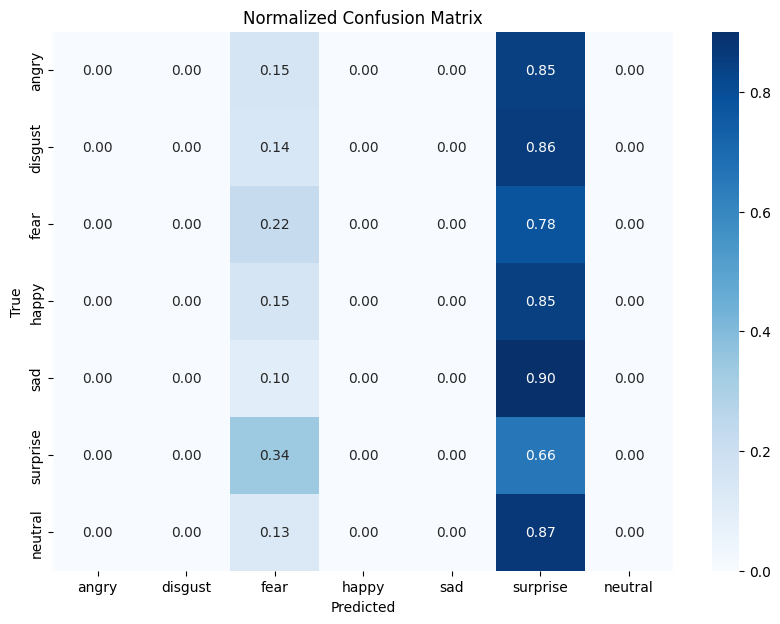

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


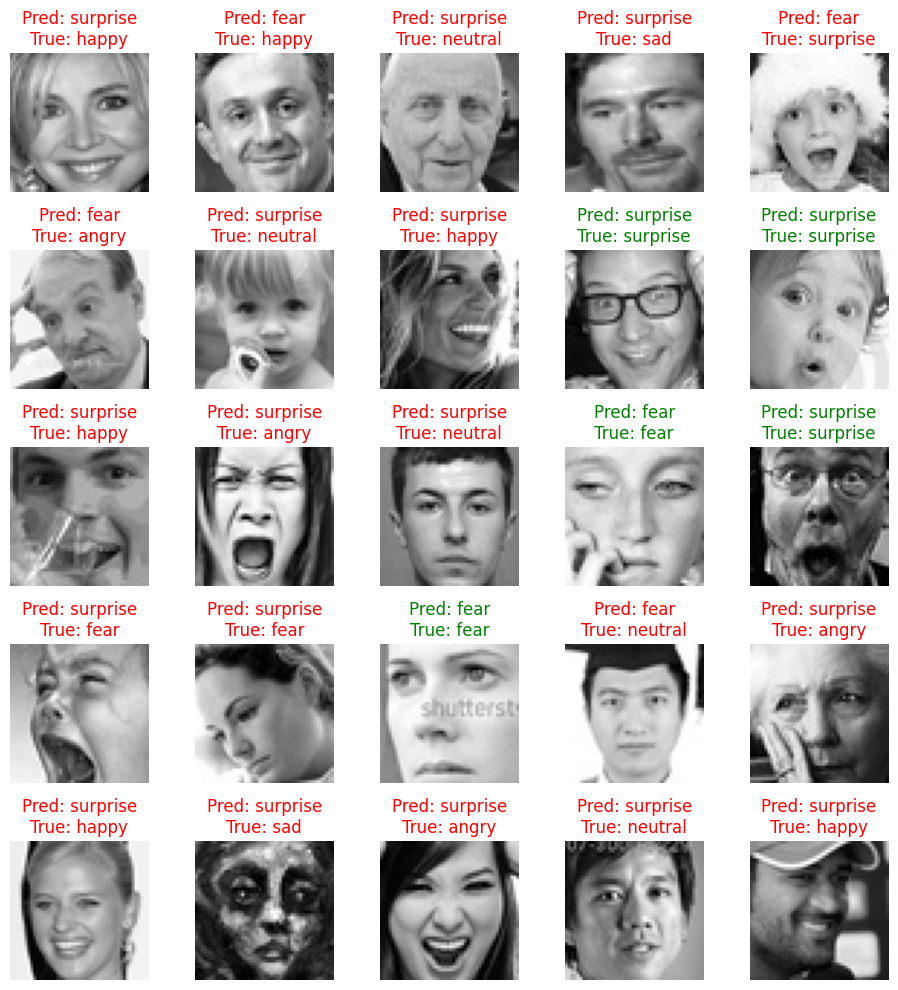

In [19]:
# SAVE MODEL, if model is defined
if model is not None:
    model.save("emotion_recognition_model.h5")
    print("Model saved as emotion_recognition_model.h5")
else:
    # Load model
    model = tf.keras.models.load_model("emotion_recognition_model.h5")
    print("Model loaded from emotion_recognition_model.h5")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

# Evaluate model
evaluation = model.evaluate(x_test, y_test_encoded)

# print evaluation
print(evaluation)

# Predict test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Display normalized confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    xticklabels=classes,
    yticklabels=classes,
    cmap="Blues",
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()

# 5x5 matrix with random pictures from the test set, labeled with the predicted emotion and the true emotion; text color is green if the prediction is correct, red otherwise
import random

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    index = random.randint(0, len(x_test) - 1)
    img = x_test[index]
    img = np.reshape(img, [1, 48, 48, 1])
    prediction = model.predict(img)
    emotion = classes[np.argmax(prediction)]
    true_emotion = classes[y_test[index]]
    color = "g" if emotion == true_emotion else "r"
    # Image back to original size
    img = x_test[index]
    img = np.reshape(img, [48, 48])
    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {emotion}\nTrue: {true_emotion}", color=color)
    plt.axis("off")
    plt.tight_layout()

plt.show()

In [22]:
evaluation[0]

2.0127696990966797

# Hyperparam Optimization

In [42]:
import numpy as np

def gaussian_peak(min_value, max_value, length, sharpness=0.01):
    offset = length // 2 + length // 5
    x = np.linspace(0, length - 1, length)
    peak_position = (max_value - min_value) / 2 + min_value
    peak = np.exp(-sharpness * ((x - offset) ** 2))
    scaled_peak = (peak - np.min(peak)) / (np.max(peak) - np.min(peak))
    scaled_peak = (max_value - min_value) * scaled_peak + min_value
    return np.round(scaled_peak).astype(int)

# Example usage:
min_value = 4
max_value = 32
length = 7

array_with_gaussian_peak = gaussian_peak(min_value, max_value, length)
print(array_with_gaussian_peak)

[ 4 16 25 30 32 30 25]


In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import optuna
import densenet
from tensorflow.keras import optimizers
import tensorflow as tf
import numpy as np
from util import evaluate

input_shape = (48, 48, 1)

def objective(trial):
    # Suggest the number of dense blocks
    num_blocks = trial.suggest_int('num_blocks', 2, 10)
    
    # Suggest the max and min layers per block
    min_layers = trial.suggest_int('min_layers', 4, 8)
    max_layers = trial.suggest_int('max_layers', 16, 32)
    num_layers_per_block = gaussian_peak(min_layers, max_layers, num_blocks)
    print("XXX", num_layers_per_block)
    # Suggest other parameters
    growth_rate = trial.suggest_categorical('growth_rate', [16, 32, 48])
    reduction = trial.suggest_uniform('reduction', 0.4, 0.6)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.4)
    l2_regularization = trial.suggest_loguniform('l2_regularization', 1e-6, 1e-3)
    
    # Define the model using the suggested parameters
    args = dict(
        input_shape=input_shape,
        num_blocks=num_blocks,
        num_layers_per_block=num_layers_per_block,
        growth_rate=growth_rate,
        reduction=reduction,
        num_classes=7,  # Assuming the number of classes is fixed
        dropout_rate=dropout_rate,
        l2_regularization=l2_regularization
    )
    
    model = densenet.DenseNet(**args)
    model.build((None, *input_shape))
    model.compile(
        optimizer=optimizers.Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    history = model.fit(
        train_ds,
        class_weight=class_weights_dict,
        epochs=20,
        validation_data=test_ds,
        callbacks=[reduce_lr, early_stopping],
    )
    plot_history(history)
    evaluate(model)
    loss, accuracy = model.evaluate(validation_data, x_test, y_test, y_test_encoded)
    return loss

In [59]:
study = optuna.create_study(direction='minimize', study_name="custom-densenet", storage='sqlite:///optuna.db', load_if_exists=True)

[I 2024-07-10 23:37:31,313] Using an existing study with name 'custom-densenet' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=50)

XXX [ 5 12 16 17 16]


/tmp/hagemann/ipykernel_57540/1086897384.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  reduction = trial.suggest_uniform('reduction', 0.4, 0.6)
/tmp/hagemann/ipykernel_57540/1086897384.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.4)
/tmp/hagemann/ipykernel_57540/1086897384.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_regularization = trial.suggest_loguniform('l2_regularization', 1e-6, 1e-3)


Epoch 1/20


/data/hagemann/ml/venv/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'dense_net_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [ ]:
# Print the top 10 parameter sets
completed_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

best_trials = sorted(completed_trials, key=lambda trial: trial.value)[:10]
for i, trial in enumerate(best_trials):
    print(f"Rank {i+1}: Loss = {trial.value}, Params = {trial.params}")
Key Components:
